In [1]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\adnaa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Importing Libraries

In [7]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import os 
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords

### Loading the dataset

In [3]:
data =pd.read_csv(r"src\data\AmazonEcho2Reviews.csv")

### Calcualting the Target column SentimentLabel

In [4]:
data['SentimentLabel']=data['Rating'].apply(lambda x: "Positive" if x>3 else('Neutral' if x==3 else 'Negative'))

#### How data looks like

In [5]:
data.head()

,Pageurl,Title,Review Text,Review Color,User Verified,Review Date,Review Useful Count,Configuration Text,Rating,Declaration Text,SentimentLabel
0,https://www.amazon.com/All-New-Amazon-Echo-Dot...,Three Stars,Not great speakers,Black,Verified Purchase,10/3/2017,NaN,Echo Dot,3,NaN,Neutral
1,https://www.amazon.com/All-New-Amazon-Echo-Dot...,Four Stars,Great little gagit,White,Verified Purchase,9/26/2017,NaN,Echo Dot,4,NaN,Positive
2,https://www.amazon.com/All-New-Amazon-Echo-Dot...,Awesome!,Awesome 👏🏽,White,Verified Purchase,9/8/2017,NaN,Echo Dot,5,NaN,Positive
3,https://www.amazon.com/All-New-Amazon-Echo-Dot...,Five Stars,Love my Echo,Black,Verified Purchase,10/19/2017,NaN,Echo Dot,5,NaN,Positive
4,https://www.amazon.com/All-New-Amazon-Echo-Dot...,Five Stars,Great device,Black,Verified Purchase,9/17/2017,NaN,Echo Dot,5,NaN,Positive


#### how big is our dataset

In [6]:
data.shape

(6855, 11)

#### checking the meta information about the dataset

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6855 entries, 0 to 6854
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pageurl              6855 non-null   object 
 1   Title                6855 non-null   object 
 2   Review Text          6850 non-null   object 
 3   Review Color         6855 non-null   object 
 4   User Verified        6641 non-null   object 
 5   Review Date          6855 non-null   object 
 6   Review Useful Count  28 non-null     float64
 7   Configuration Text   6855 non-null   object 
 8   Rating               6855 non-null   int64  
 9   Declaration Text     6 non-null      object 
 10  SentimentLabel       6855 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 589.2+ KB


#### Checking the missing values

In [8]:
data.isna().sum()

Pageurl                   0
Title                     0
Review Text               5
Review Color              0
User Verified           214
Review Date               0
Review Useful Count    6827
Configuration Text        0
Rating                    0
Declaration Text       6849
SentimentLabel            0
dtype: int64

<ol>
    <li>Removing the missing values from the "Review Text" column</li>
    <li>Replacing the missing values in the "User Verified" column with "Not Verified" value</li>
    <li>Since 'Review Useful Count','Declaration Text','Pageurl' contains more than 90% of records as null, Droping such columns</li>
</ol>

In [9]:
data.dropna(subset=['Review Text'],inplace=True)
data['User Verified']=data['User Verified'].fillna('Not Verified')
if 'Review Useful Count' in data.columns:
    data.drop(['Review Useful Count','Declaration Text','Pageurl'],axis=1,inplace=True)


In [10]:
data['review'] = data['Title'] + ' ' + data['Review Text'] + ' ' + data['Review Color']+ ' ' + data['User Verified']

In [11]:
data.drop(['Title','Review Text','Review Color','User Verified','Rating','Configuration Text','Review Date'],axis=1,inplace=True)

In [12]:
### Encoding the target column
data['SentimentLabel']=data['SentimentLabel'].map({'Positive':2,'Neutral':1,'Negative':0})

In [13]:
data.head()

,SentimentLabel,review
0,1,Three Stars Not great speakers Black Verified ...
1,2,Four Stars Great little gagit White Verified P...
2,2,Awesome! Awesome 👏🏽 White Verified Purchase
3,2,Five Stars Love my Echo Black Verified Purchase
4,2,Five Stars Great device Black Verified Purchase


In [14]:
data

,SentimentLabel,review
0,1,Three Stars Not great speakers Black Verified ...
1,2,Four Stars Great little gagit White Verified P...
2,2,Awesome! Awesome 👏🏽 White Verified Purchase
3,2,Five Stars Love my Echo Black Verified Purchase
4,2,Five Stars Great device Black Verified Purchase
...,...,...
6850,2,In love with Alexa!! This is so much fun! I lo...
6851,2,Five Stars I'm having a lot of fun with it. Wh...
6852,1,We would still like to exchange for something ...
6853,2,Simply fabulous! I have now set Alexa up to co...


### Data Pre-preocessing

In [15]:
def remove_html_tags(text):
    text=text.lower()
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF" 
                           u"\U0001F680-\U0001F6FF" 
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

dd={
    "didn't":"did not",
    "don't":"do not",
    "doesn't":"does not",
    "wasn't":"was not",
    "isn't":"is not",
    "aren't":"are not",
    "weren't":"were not",
    "haven't":"have not",
    'didnt':"did not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    "wouldn't":"would not",
    "can't":"can not",
    "couldn't":"could not",
    "shouldn't":"should not",
    "mightn't":"might not",
    "mustn't":"must not",
    "i'm":"i am",
    "you're":"you are",
    "he's":"he is",
    "she's":"she is",
    "it's":"it is",
    "we're":"we are",
    "they're":"they are",
    "i'll":"i will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "we'll":"we will",
    "they'll":"they will",
    "i've":"i have",
    "you've":"you have",
    "we've":"we have",
    "they've":"they have",
    "i'd":"i would",
    "you'd":"you would",
    "he'd":"he would",
    "she'd":"she would",
    "we'd":"we would",
    "they'd":"they would",
    "i'd":"i had",
    "you'd":"you had",
    "he'd":"he had",
    "she'd":"she had",
    "we'd":"we had",
    "they'd":"they had",
    "i'll":"i shall"
}
def chat_treatment(text):
    new_text=[]
    for word in text.split():
        if word in dd.keys():
            new_text.append(dd[word])
        else:
            new_text.append(word)
    return " ".join(new_text)


def remove_punctuations(text):
    import string
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    new_text = []
    stops=stopwords.words('english')
    for word in text.split():
        if not word in stops:
            new_text.append(word)
    return " ".join(new_text)

def lemmatization(text):
    import spacy
    new_text=[]
    nlp=spacy.load('en_core_web_sm')
    doc=nlp(text)
    for token in doc:
        new_text.append(token.lemma_)
    return " ".join(new_text)

### Applying Data-preprocessing techniques

In [16]:
data['review'] = data['review'].apply(remove_html_tags)
data['review'] = data['review'].apply(remove_urls)
data['review'] = data['review'].apply(remove_emojis) 
data['review'] = data['review'].apply(chat_treatment)   
data['review'] = data['review'].apply(remove_punctuations)
data['review'] = data['review'].apply(remove_stopwords)
data['review'] = data['review'].apply(lemmatization)

In [17]:
data.head()

,SentimentLabel,review
0,1,three star great speaker black verified purchase
1,2,four star great little gagit white verify purc...
2,2,awesome awesome white verify purchase
3,2,five star love echo black verify purchase
4,2,five star great device black verify purchase


### Saving the Cleaned-Data in Artifacts

In [22]:
if not os.path.exists("src/artifacts/cleaned_reviews_data.csv"):
    data.to_csv("src/artifacts/cleaned_reviews_data.csv")

### Loading cleaned data

In [11]:
df=pd.read_csv("src/artifacts/cleaned_reviews_data.csv",usecols=['review','SentimentLabel'])
df.head()

,SentimentLabel,review
0,1,three star great speaker black verified purchase
1,2,four star great little gagit white verify purc...
2,2,awesome awesome white verify purchase
3,2,five star love echo black verify purchase
4,2,five star great device black verify purchase


#### Calculating the frequency of each word

In [68]:
freq={}
for text in df['review']:
    for word in text.split():
        if not word in freq.keys():
            freq[word]=1
        else:
            freq[word]+=1

#top 100
i=0
for w in sorted(freq, key=freq.get, reverse=True):
    print(w,":", freq[w])
    if i==100:
        break
    i+=1 


purchase : 6982
black : 5425
verify : 5415
love : 2880
star : 2744
echo : 2202
dot : 2122
alexa : 1897
five : 1894
great : 1861
use : 1593
white : 1481
verified : 1436
work : 1408
music : 1371
get : 1295
one : 1141
like : 982
good : 959
play : 861
speaker : 859
well : 856
device : 836
fun : 788
product : 784
buy : 784
thing : 749
amazon : 718
time : 716
would : 669
ask : 636
sound : 592
much : 561
set : 545
home : 539
really : 515
need : 494
easy : 492
say : 490
know : 478
little : 455
question : 438
go : 419
connect : 409
room : 406
make : 389
lot : 383
still : 378
day : 372
house : 367
want : 366
tell : 365
four : 350
enjoy : 344
also : 343
awesome : 341
smart : 340
give : 336
not : 336
answer : 332
could : 329
even : 327
weather : 325
new : 323
app : 321
think : 319
find : 314
phone : 308
nice : 307
listen : 306
voice : 305
light : 303
gift : 302
amazing : 292
alarm : 269
every : 264
turn : 263
learn : 263
try : 263
way : 262
two : 256
feature : 251
three : 244
far : 244
bluetooth :

### Generating the word-cloud from frequency of words

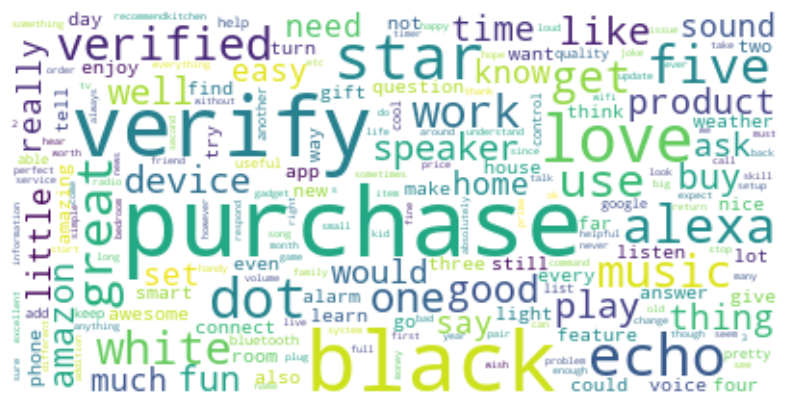

In [31]:
from wordcloud import WordCloud
wordc = WordCloud(max_font_size=50, max_words=200, background_color="white").generate_from_frequencies(freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Word-cloud of positive reviews

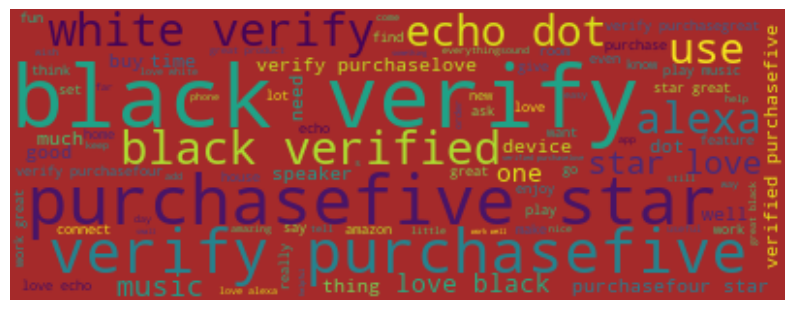

In [32]:
plt.figure(figsize=(10,5))
positive_cloud = WordCloud(max_words=300, background_color='brown', height=150, width=400).generate("".join(data[data['SentimentLabel']==2].review))
plt.imshow(positive_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

#### Word-Cloud for Negative Reviews

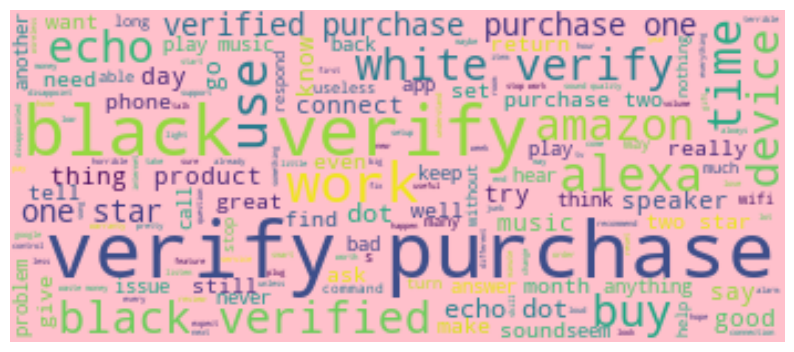

In [35]:
plt.figure(figsize=(10,7))
negative_clouds=WordCloud(max_words=300, height=150, width=350, background_color='pink').generate(" ".join(data[data['SentimentLabel']==0].review))
plt.imshow(negative_clouds,interpolation='bilinear')
plt.axis('off')
plt.show()

#### Word-cloud for Neutral Reviews

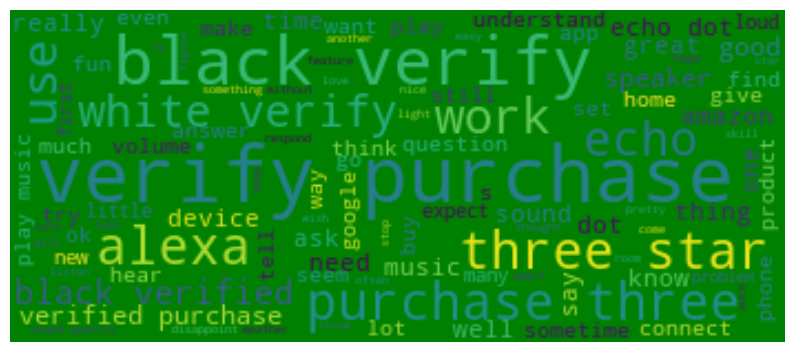

In [38]:
plt.figure(figsize=(10,7))
neutral_clouds=WordCloud(max_words=300, height=150, width=350, background_color='green').generate(" ".join(data[data['SentimentLabel']==1].review))
plt.imshow(neutral_clouds,interpolation='bilinear')
plt.axis('off')
plt.show()

### Data Split

In [34]:
from sklearn.model_selection import train_test_split
X=df['review']
Y=df['SentimentLabel']
x_train,x_test,y_train,y_test = train_test_split(X,Y, stratify=Y, test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)

(5480,)
(1370,)


#### Text Vectorization

In [35]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [36]:
bag_of_words = CountVectorizer(max_features=1000,stop_words='english',ngram_range=(1,5))
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words="english",ngram_range=(1,5))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

#### Preprocessing the reviews for the Word2Vec

In [37]:
text_review=df['review'].apply(simple_preprocess) #tokenizing each word in a review
text_review

0       [three, star, great, speaker, black, verified,...
1       [four, star, great, little, gagit, white, veri...
2             [awesome, awesome, white, verify, purchase]
3       [five, star, love, echo, black, verify, purchase]
4       [five, star, great, device, black, verify, pur...
                              ...                        
6845    [love, alexa, much, fun, love, black, verify, ...
6846      [five, star, lot, fun, white, verify, purchase]
6847    [would, still, like, exchange, something, suit...
6848    [simply, fabulous, set, alexa, control, light,...
6849    [bummer, even, make, voice, trial, shame, try,...
Name: review, Length: 6850, dtype: object

#### Specifying the parameters for Word2Vec

In [38]:
word2vec_model=Word2Vec(
    window=6,
    min_count=2, #ignore the reviews having two or less than 2 words for training
    workers=4, #number of cpu threads
    vector_size=100, #vector-size to which each word will be converted into
    epochs=500
)

In [39]:
word2vec_model.build_vocab(text_review, #tokenizer review words
                           progress_per=1000)
word2vec_model.corpus_total_words

130288

#### Training Word2Vec Model

In [ ]:
if not os.path.exists("src/artifacts/trained_word2vec_model.model"):
  word2vec_model.train(text_review, #tokenized reviews
                     total_examples=word2vec_model.corpus_count,#number of reviews
                       epochs=word2vec_model.epochs)

(44247641, 65144000)

#### Saving the Word2Vec model

In [ ]:
if not os.path.exists("src/artifacts/trained_word2vec_model.model"):
    word2vec_model.save("src/artifacts/trained_word2vec_model.model")

#### Loading the pretrained own Word2Vec model

In [29]:
# Load the saved model
loaded_model = Word2Vec.load("src/artifacts/trained_word2vec_model.model")

In [30]:
loaded_model.wv.most_similar("bad")

[('inferior', 0.32200750708580017),
 ('disappoint', 0.30567726492881775),
 ('implementation', 0.30531349778175354),
 ('troubleshoot', 0.3050963282585144),
 ('vizio', 0.2952633798122406),
 ('good', 0.2927005887031555),
 ('itcool', 0.2866816818714142),
 ('internal', 0.2742174565792084),
 ('mediocre', 0.2738818824291229),
 ('greatest', 0.26923760771751404)]

### 1. Using CountVectorizer and TFIDF

In [40]:
x_train_bag=bag_of_words.fit_transform(x_train)
x_train_tfidf=tfidf_vectorizer.fit_transform(x_train)
x_test_bag=bag_of_words.transform(x_test)
x_test_tfidf=tfidf_vectorizer.transform(x_test)

In [45]:
print(x_train_bag.shape)
print(x_test_bag.shape)
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(5480, 1000)
(1370, 1000)
(5480, 1000)
(1370, 1000)


### Using Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
lr_bag=LogisticRegression()
lr_tf=LogisticRegression()

In [50]:
lr_bag.fit(x_train_bag,y_train)
lr_tf.fit(x_train_tfidf,y_train)

LogisticRegression()

In [51]:
y_pred_bag=lr_bag.predict(x_test_bag)
y_pred_tf=lr_tf.predict(x_test_tfidf)

In [52]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [54]:
bag_acc=accuracy_score(y_test,y_pred_bag)
tf_acc=accuracy_score(y_test,y_pred_tf)
print("Accuracy via Bow",bag_acc)
print("Accuracy via tfidf",tf_acc)

Accuracy via Bow 0.8394160583941606
Accuracy via tfidf 0.8525547445255475


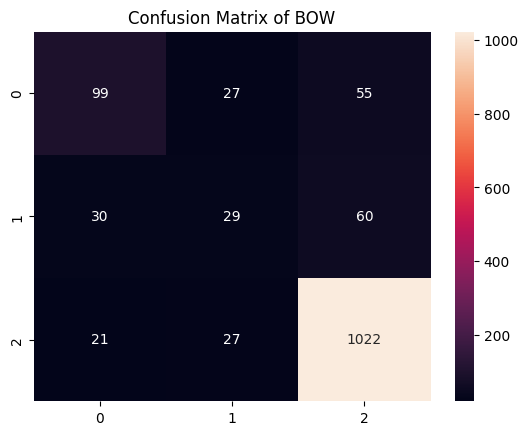

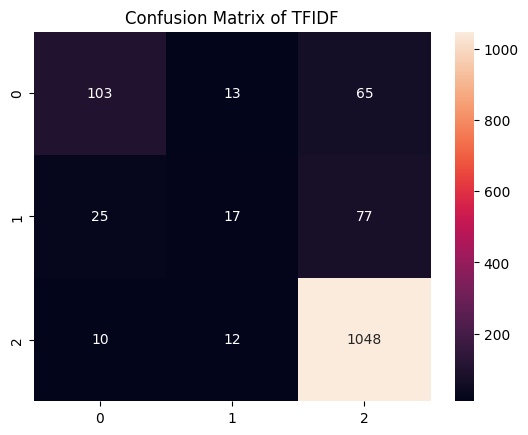

In [65]:
bag_conf=confusion_matrix(y_test,y_pred_bag)
tf_conf=confusion_matrix(y_test,y_pred_tf)
sns.heatmap(bag_conf,annot=True,fmt="d")
plt.title("Confusion Matrix of BOW")
plt.show()
sns.heatmap(tf_conf,annot=True,fmt="d")
plt.title("Confusion Matrix of TFIDF")
plt.show()

In [66]:
bag_cr=classification_report(y_test,y_pred_bag)
tf_cr=classification_report(y_test,y_pred_tf)
print("confusion_matrix of BOW:\n",bag_cr)
print("confusion_matrix of tfidf:\n",tf_cr)

confusion_matrix of BOW:
               precision    recall  f1-score   support

           0       0.66      0.55      0.60       181
           1       0.35      0.24      0.29       119
           2       0.90      0.96      0.93      1070

    accuracy                           0.84      1370
   macro avg       0.64      0.58      0.60      1370
weighted avg       0.82      0.84      0.83      1370

confusion_matrix of tfidf:
               precision    recall  f1-score   support

           0       0.75      0.57      0.65       181
           1       0.40      0.14      0.21       119
           2       0.88      0.98      0.93      1070

    accuracy                           0.85      1370
   macro avg       0.68      0.56      0.59      1370
weighted avg       0.82      0.85      0.83      1370

